In [19]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading csv files
engagement = pd.read_csv('takehome_user_engagement.csv')
df = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")

In [3]:
# First glance
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


__<p> Challenge:<p/>__
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

__Answer__:

First, we need to create "adopted user" list from df dataset based on the criteria given in the challenge. 

In [5]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['time_stamp'] = engagement['time_stamp'].dt.floor(
    'd').astype(np.int64)
engagement = engagement.sort_values(
    ['user_id', 'time_stamp']).drop_duplicates()

In [6]:
q = engagement.groupby('user_id')['time_stamp'].rolling(window=3)
qq = pd.to_timedelta((q.max() - q.min())).dt.days
adopted_user = qq[qq < 8].index.get_level_values('user_id').tolist()

In [7]:
adopted_user = np.unique(adopted_user)
print('Number of Adopted Users:{}'.format(len(adopted_user)))
print('Ratio of Apopted Users to all Users: {}'.format(len(adopted_user)/len(df)))

Number of Adopted Users:1656
Ratio of Apopted Users to all Users: 0.138


We determined our adopted user, now we will predict which factor are important to become an adopted user.

In [8]:
df['last_session_creation_time'] = pd.to_datetime(
    df['last_session_creation_time'], unit='s')
df['adopted'] = df.object_id.apply(lambda x: 1 if x in adopted_user else 0)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 1.0+ MB


We will drop the columns that are not part of the prediction model such as name, email, etc. Also we will drop the columns we already used creating adopted user column (creation_time, last_session_creation_time). Last, we will drop invited_by_user_id columns since there are a lot of NAN data in that.

In [10]:
df = df.drop(['creation_time', 'name', 'email', 'last_session_creation_time',
              'invited_by_user_id', 'object_id'], axis=1)
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


In [11]:
df = pd.get_dummies(df, drop_first=True) # add dummy for correlation map
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0,0
1,0,0,1,1,1,0,0,0
2,0,0,94,0,1,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,193,0,0,0,0,0


We can show the feature correlation heat map below

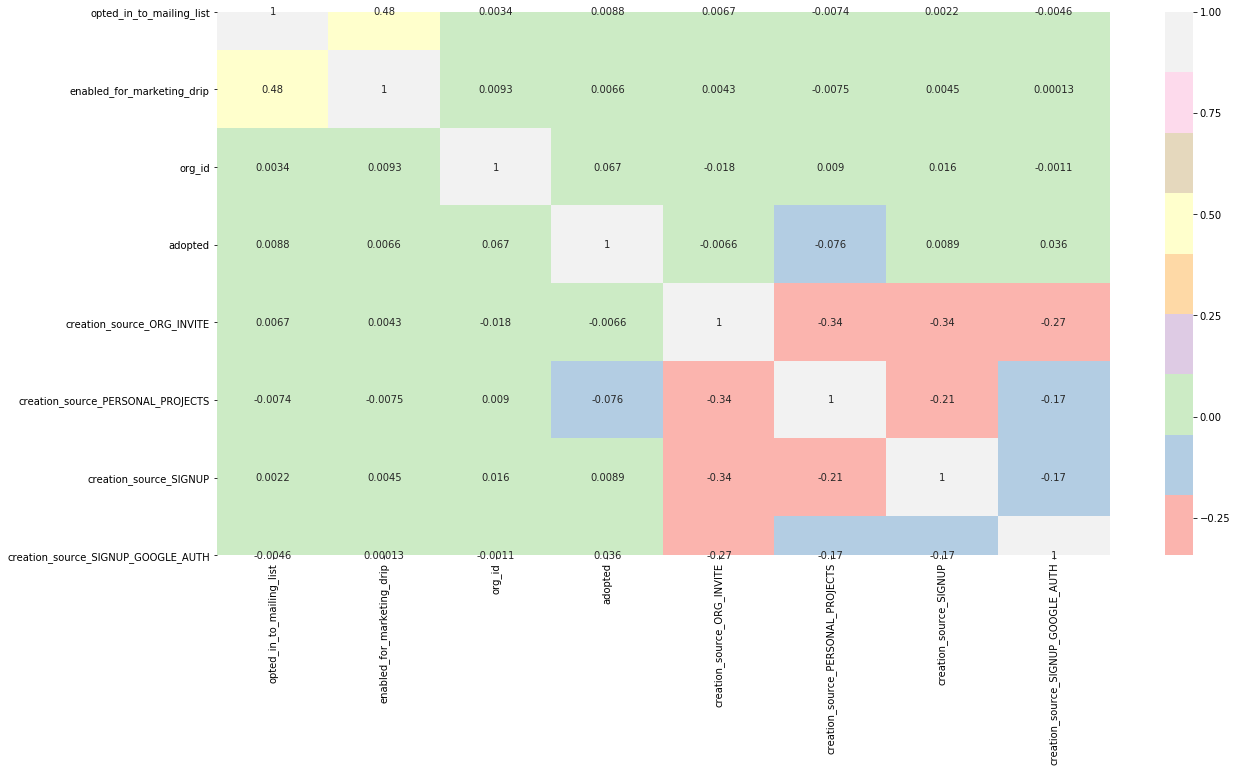

In [24]:
cols = list(df.columns.values)
cols[3], cols[-1] = cols[-1], cols[3]
df = df[cols]
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 10))
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="Pastel1")

Now, we will use Logistic Regression and Random Forest Classifier on our data to predict adopted user.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [31]:
#Let's set our training and test data
X = df.drop('adopted', axis=1)
y= df.adopted

/Users/ceyhun/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


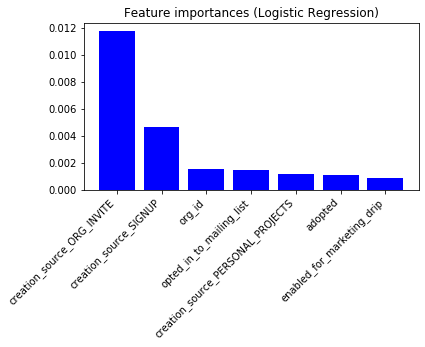

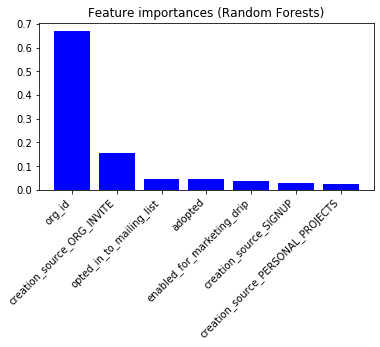

In [37]:
clf = LogisticRegressionCV(max_iter=3000) # fitting logistic regression model
clf.fit(X, y)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(7), coefs[indices[:12]],
       color="b", align="center")
plt.xticks(range(7), df.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

# Fitting Random Forest
clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6)
clf.fit(X, y)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(7), coefs[indices[:12]],
       color="b", align="center")
plt.xticks(range(7), df.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

By looking at the plot above, we can easly say that the most important feature is org_id - the organization (group of users) they belong to,ORG_INVITE (invited to an organization (as a full member).